In [1]:
# %% 
# 1. Imports
import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

try:
    import pmdarima as pm
except ImportError:
    pm = None


In [2]:
# %%
# 2. Load dataset
data_path = "data.csv"
df = pd.read_csv(data_path)
print("Raw shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Raw shape: (396, 26)
Columns: ['state', 'district', 'coordinates_lat', 'coordinates_lon', 'year', 'month', 'rainfall_mm', 'temperature_c', 'humidity_percent', 'pH_level', 'turbidity_ntu', 'dissolved_solids_mg_per_l', 'total_coliform_mpn_100ml', 'je_cases', 'diarrhea_cases', 'enteric_fever_cases', 'vector_density', 'gi_disorders', 'skin_allergies', 'respiratory_issues', 'mining_proximity', 'population_density', 'tribal_population_percent', 'monsoon_season', 'outbreak_risk_score', 'disease_outbreak']


,state,district,coordinates_lat,coordinates_lon,year,month,rainfall_mm,temperature_c,humidity_percent,pH_level,...,vector_density,gi_disorders,skin_allergies,respiratory_issues,mining_proximity,population_density,tribal_population_percent,monsoon_season,outbreak_risk_score,disease_outbreak
0,Meghalaya,East Jaintia Hills,25.3947,92.2622,2021,1,59.934283,24.590754,63.893886,4.718424,...,Low,52,29,22,Yes,370,84,0,1.37,1
1,Meghalaya,West Jaintia Hills,25.4525,92.2053,2021,1,65.348695,27.947924,53.189362,3.480436,...,Low,44,47,23,Yes,149,77,0,1.33,1
2,Meghalaya,East Khasi Hills,25.5788,91.8933,2021,1,41.065171,23.291999,77.193933,6.103292,...,Low,8,9,1,No,161,93,0,0.31,0
3,Meghalaya,Ri Bhoi,25.9304,92.0789,2021,1,56.483975,28.906066,72.600043,7.028943,...,Low,7,2,3,No,207,81,0,0.31,0
4,Meghalaya,South West Khasi Hills,25.3047,90.9789,2021,1,69.252826,18.903828,63.322461,6.620111,...,Low,8,5,2,No,323,70,0,0.40,0


In [3]:
df[['je_cases', 'diarrhea_cases',
       'enteric_fever_cases', ]].head()
df.columns
df['je_cases'].value_counts()
df.columns

Index(['state', 'district', 'coordinates_lat', 'coordinates_lon', 'year',
       'month', 'rainfall_mm', 'temperature_c', 'humidity_percent', 'pH_level',
       'turbidity_ntu', 'dissolved_solids_mg_per_l',
       'total_coliform_mpn_100ml', 'je_cases', 'diarrhea_cases',
       'enteric_fever_cases', 'vector_density', 'gi_disorders',
       'skin_allergies', 'respiratory_issues', 'mining_proximity',
       'population_density', 'tribal_population_percent', 'monsoon_season',
       'outbreak_risk_score', 'disease_outbreak'],
      dtype='object')

In [4]:
# %%
# 3. Define key columns
target_col = ['je_cases', 'diarrhea_cases',
       'enteric_fever_cases']  # can change to diarrhea_cases, enteric_fever_cases etc
date_col = None
if "date" in df.columns:
    date_col = "date"
elif {"year","month"}.issubset(df.columns):
    df["date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-01")
    date_col = "date"

district_col = "district"

# candidate symptom and water-quality columns
symptom_candidates = ["gi_disorders","skin_allergies","respiratory_issues",'vector_density']
possible_wq_cols = ['rainfall_mm', 'temperature_c', 'humidity_percent', 'pH_level',
       'turbidity_ntu', 'dissolved_solids_mg_per_l',
       'total_coliform_mpn_100ml','monsoon_season']

print("Date col:", date_col)
print("District col:", district_col)
print("Target col:", target_col)


Date col: date
District col: district
Target col: ['je_cases', 'diarrhea_cases', 'enteric_fever_cases']


In [5]:
# %%
# 4. Keep relevant columns
targets = ['je_cases', 'diarrhea_cases', 'enteric_fever_cases']

all_features = [
    'rainfall_mm', 'temperature_c', 'humidity_percent', 'pH_level',
    'turbidity_ntu', 'dissolved_solids_mg_per_l',
    'total_coliform_mpn_100ml', 'vector_density', 'gi_disorders',
    'skin_allergies', 'respiratory_issues', 'mining_proximity',
    'population_density', 'tribal_population_percent', 'monsoon_season',
    'outbreak_risk_score', 'disease_outbreak'
]

# Keep all targets + exogenous features
proc = df[[date_col, district_col] + targets + all_features].copy()

# Convert datatypes
proc["date"] = pd.to_datetime(proc["date"], errors="coerce")
proc["district"] = proc["district"].astype(str)

for t in targets:
    proc[t] = pd.to_numeric(proc[t], errors="coerce").fillna(0)

for c in all_features:
    proc[c] = pd.to_numeric(proc[c], errors="coerce").fillna(0)

print()
proc.head()


,date,district,je_cases,diarrhea_cases,enteric_fever_cases,rainfall_mm,temperature_c,humidity_percent,pH_level,turbidity_ntu,...,vector_density,gi_disorders,skin_allergies,respiratory_issues,mining_proximity,population_density,tribal_population_percent,monsoon_season,outbreak_risk_score,disease_outbreak
0,2021-01-01,East Jaintia Hills,0,29,2,59.934283,24.590754,63.893886,4.718424,13.829233,...,0.0,52,29,22,0.0,370,84,0,1.37,1
1,2021-01-01,West Jaintia Hills,0,25,4,65.348695,27.947924,53.189362,3.480436,16.777757,...,0.0,44,47,23,0.0,149,77,0,1.33,1
2,2021-01-01,East Khasi Hills,0,4,8,41.065171,23.291999,77.193933,6.103292,0.821666,...,0.0,8,9,1,0.0,161,93,0,0.31,0
3,2021-01-01,Ri Bhoi,0,11,1,56.483975,28.906066,72.600043,7.028943,1.315713,...,0.0,7,2,3,0.0,207,81,0,0.31,0
4,2021-01-01,South West Khasi Hills,0,5,4,69.252826,18.903828,63.322461,6.620111,3.724083,...,0.0,8,5,2,0.0,323,70,0,0.40,0


In [6]:
# %%
# 5. Symptom encoding
symptom_onehot_cols = []
if len(symptom_candidates) > 0:
    for c in symptom_candidates:
        if c in proc.columns:
            proc[c] = proc[c].fillna(0).astype(float)
    symptom_onehot_cols = [c for c in symptom_candidates if c in proc.columns]

print("Symptom one-hot cols:", symptom_onehot_cols)


Symptom one-hot cols: ['gi_disorders', 'skin_allergies', 'respiratory_issues', 'vector_density']


In [7]:
# %%
# 6. Aggregate by date and district
grouped = proc.groupby(["date","district"]).agg("mean").reset_index()
print(grouped.head())


        date            district  je_cases  diarrhea_cases  \
0 2021-01-01           Bishnupur       0.0             8.0   
1 2021-01-01       Churachandpur       0.0             9.0   
2 2021-01-01  East Jaintia Hills       0.0            29.0   
3 2021-01-01    East Khasi Hills       0.0             4.0   
4 2021-01-01         Imphal East       2.0            16.0   

   enteric_fever_cases  rainfall_mm  temperature_c  humidity_percent  \
0                  8.0    16.742138      25.174626         61.229801   
1                  2.0    49.003667      26.331458         54.338644   
2                  2.0    59.934283      24.590754         63.893886   
3                  8.0    41.065171      23.291999         77.193933   
4                  5.0    30.195508      25.188474         63.022157   

   pH_level  turbidity_ntu  ...  vector_density  gi_disorders  skin_allergies  \
0  6.628515       2.357787  ...             0.0           5.0             3.0   
1  7.587317       1.073070  ... 

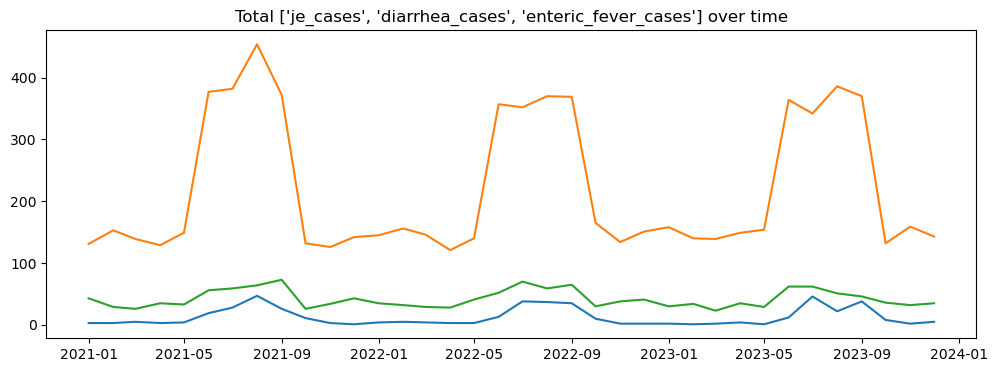

In [8]:
# %%
# 7. EDA — plot total cases over time
series_all = grouped.groupby("date")[target_col].sum()
plt.figure(figsize=(12,4))
plt.plot(series_all)
plt.title(f"Total {target_col} over time")
plt.show()


In [9]:
# %%
# 8. Prepare a single district time series
def prepare_ts(district):
    df_d = grouped[grouped["district"]==district].set_index("date").sort_index()
    idx = pd.date_range(df_d.index.min(), df_d.index.max(), freq="D")
    df_d = df_d.reindex(idx).fillna(method="ffill").fillna(0)
    df_d["district"] = district
    return df_d

sample = prepare_ts(grouped["district"].iloc[0])
print()
sample.head()

,district,je_cases,diarrhea_cases,enteric_fever_cases,rainfall_mm,temperature_c,humidity_percent,pH_level,turbidity_ntu,dissolved_solids_mg_per_l,...,vector_density,gi_disorders,skin_allergies,respiratory_issues,mining_proximity,population_density,tribal_population_percent,monsoon_season,outbreak_risk_score,disease_outbreak
2021-01-01,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,0.0,5.0,3.0,0.0,0.0,253.0,56.0,0.0,0.29,1.0
2021-01-02,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,0.0,5.0,3.0,0.0,0.0,253.0,56.0,0.0,0.29,1.0
2021-01-03,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,0.0,5.0,3.0,0.0,0.0,253.0,56.0,0.0,0.29,1.0
2021-01-04,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,0.0,5.0,3.0,0.0,0.0,253.0,56.0,0.0,0.29,1.0
2021-01-05,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,0.0,5.0,3.0,0.0,0.0,253.0,56.0,0.0,0.29,1.0


In [10]:
# %%
# Stationarity check for each target
def adf_test(series):
    res = adfuller(series.dropna())
    return {"adf": res[0], "pval": res[1]}

for t in targets:
    print(f"ADF test for {t}:")
    print(adf_test(sample[t]))
    print("-"*40)


ADF test for je_cases:
{'adf': -3.2554310440731413, 'pval': 0.016992112405038493}
----------------------------------------
ADF test for diarrhea_cases:
{'adf': -2.786468729656133, 'pval': 0.060232760463807614}
----------------------------------------
ADF test for enteric_fever_cases:
{'adf': -3.890886725408716, 'pval': 0.002102948921261618}
----------------------------------------


Seasonal decomposition for je_cases


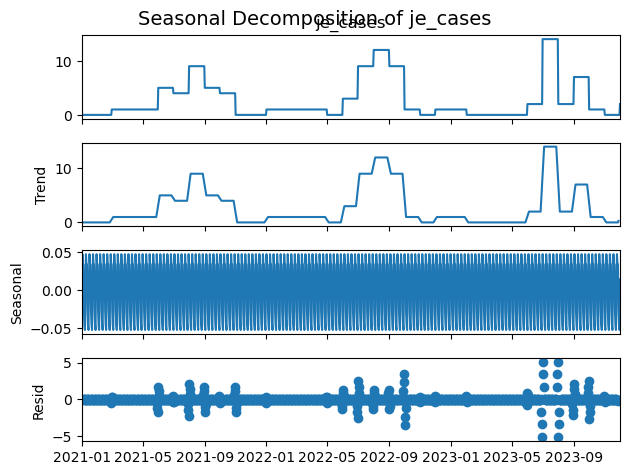

Seasonal decomposition for diarrhea_cases


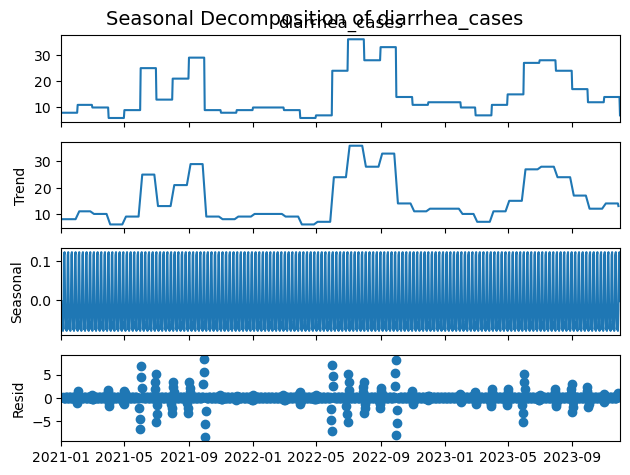

Seasonal decomposition for enteric_fever_cases


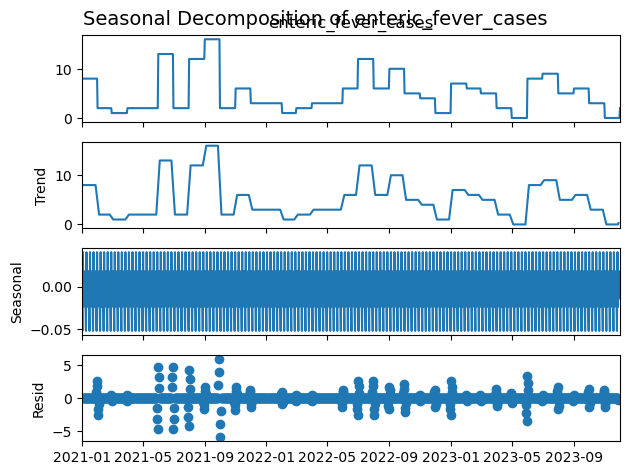

In [11]:
# %%
# 10. Seasonal decomposition for each target column
from statsmodels.tsa.seasonal import seasonal_decompose

for t in targets:  # targets = ['je_cases', 'diarrhea_cases', 'enteric_fever_cases']
    print(f"Seasonal decomposition for {t}")
    series = sample[t].dropna()
    try:
        res = seasonal_decompose(series, period=7, model="additive")
        res.plot()
        plt.suptitle(f"Seasonal Decomposition of {t}", fontsize=14)
        plt.show()
    except Exception as e:
        print(f"Could not decompose {t}: {e}")


In [12]:
# %%
# Feature engineering: lags and rolling means for multiple targets
def add_lags(df, targets, lags=[1,7], rolls=[7]):
    df2 = df.copy()
    for t in targets:
        for l in lags:
            df2[f"{t}_lag{l}"] = df2[t].shift(l)
        for r in rolls:
            df2[f"{t}_roll{r}"] = df2[t].rolling(r).mean()
    return df2.dropna()

# Apply to sample
sample = add_lags(sample, targets=['je_cases','diarrhea_cases','enteric_fever_cases'])
print()
sample.head()


,district,je_cases,diarrhea_cases,enteric_fever_cases,rainfall_mm,temperature_c,humidity_percent,pH_level,turbidity_ntu,dissolved_solids_mg_per_l,...,disease_outbreak,je_cases_lag1,je_cases_lag7,je_cases_roll7,diarrhea_cases_lag1,diarrhea_cases_lag7,diarrhea_cases_roll7,enteric_fever_cases_lag1,enteric_fever_cases_lag7,enteric_fever_cases_roll7
2021-01-08,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,1.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0
2021-01-09,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,1.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0
2021-01-10,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,1.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0
2021-01-11,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,1.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0
2021-01-12,Bishnupur,0.0,8.0,8.0,16.742138,25.174626,61.229801,6.628515,2.357787,456.078453,...,1.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0


In [17]:
# %%
# 12. Train SARIMAX with exogenous predictors
def train_sarimax(df, order=(1,1,1), seasonal=(0,0,0,0)):
    models = {}
    
    for t in target_col:
        print(f"Training SARIMAX for target: {t}")
        
        y = pd.to_numeric(df[t], errors="coerce").astype(float).squeeze()
        X = df[all_features].apply(pd.to_numeric, errors="coerce").astype(float)
        
        model = sm.tsa.statespace.SARIMAX(
            y, 
            exog=X, 
            order=order, 
            seasonal_order=seasonal,
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        
        res = model.fit(disp=False)
        models[t] = res
        
        print(f"Finished training for {t}\n")
    
    return models

y = sample[target_col]
X = sample[all_features]

if pm:
    auto = pm.auto_arima(y, exogenous=X, seasonal=True, m=7, stepwise=True)
    order, seasonal = auto.order, auto.seasonal_order
else:
    order, seasonal = (1,1,1), (0,0,0,0)

res = train_sarimax(sample, order, seasonal)
print()


Training SARIMAX for target: je_cases
Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Finished training for enteric_fever_cases




In [18]:
for target, res1 in res.items():
    print(f"===== Summary for {target} =====")
    print(res1.summary())
    print("\n")

===== Summary for je_cases =====
                               SARIMAX Results                                
Dep. Variable:               je_cases   No. Observations:                 1058
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -707.824
Date:                Tue, 16 Sep 2025   AIC                           1455.647
Time:                        23:25:53   BIC                           1554.873
Sample:                    01-08-2021   HQIC                          1493.262
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
rainfall_mm                   0.0168      0.007      2.263      0.024       0.002       0.031
temperature_c                 0.3063      0.007     4

In [24]:
def forecast_all(models, last_df, steps=30):
    forecasts = {}
    
    for target, model in models.items():
        print(f"Generating forecast for target: {target}")
        
        last_exog = last_df[all_features ].iloc[[-1]].apply(pd.to_numeric, errors="coerce").fillna(0)

        future_exog = pd.DataFrame(
            [last_exog.values[0]] * steps,
            columns=all_features 
        )
        future_exog.index = pd.date_range(
            start=last_df.index[-1] + pd.Timedelta(days=1),
            periods=steps,
            freq="D"
        )
        future_exog = future_exog.apply(pd.to_numeric, errors="coerce").fillna(0)

        pred = model.get_forecast(steps=steps, exog=future_exog)
        forecast_df = pred.summary_frame()

        # Add 'district' info if available in last_df
        if 'district' in last_df.columns:
            forecast_df['district'] = last_df['district'].iloc[0]

        forecasts[target] = forecast_df

    return forecasts


Generating forecast for target: je_cases
Generating forecast for target: diarrhea_cases
Generating forecast for target: enteric_fever_cases


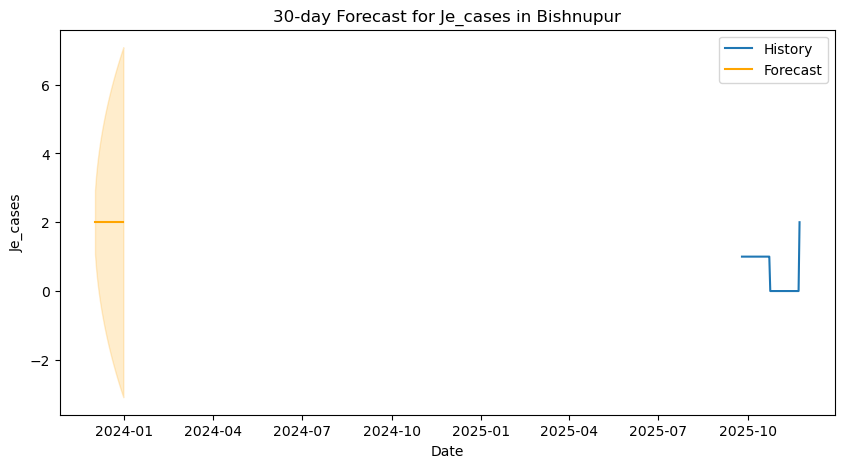

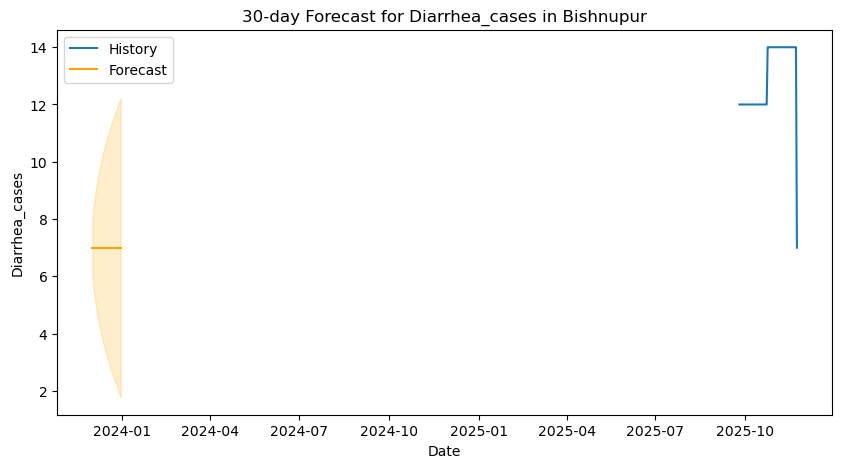

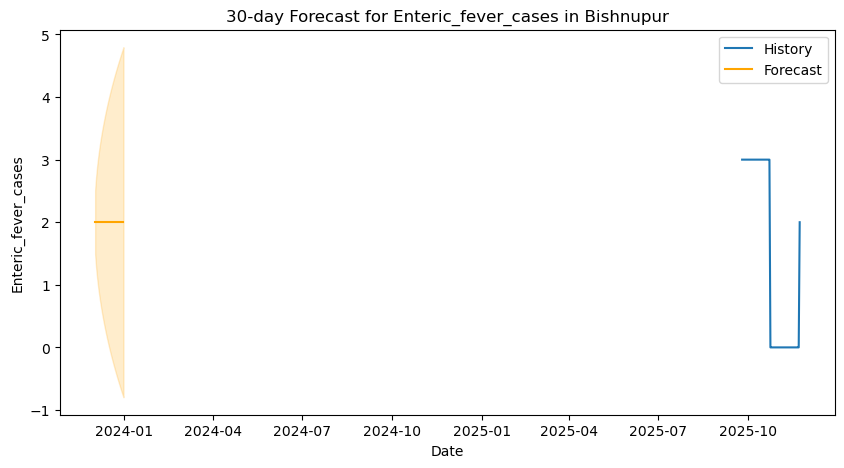

In [26]:
import matplotlib.pyplot as plt

# Make sure sample has a datetime index
sample.index = pd.date_range(start="2023-01-01", periods=len(sample), freq="D")

# Generate forecasts for all targets
forecast_results = forecast_all(res, sample, steps=30)

for target in target_col:
    pred30 = forecast_results[target]
    
    plt.figure(figsize=(10, 5))
    
    # Plot historical data
    plt.plot(sample.index[-60:], sample[target].iloc[-60:], label="History")
    
    # Plot forecasted mean
    plt.plot(pred30.index, pred30["mean"], label="Forecast", color="orange")
    
    # Confidence interval shading
    plt.fill_between(
        pred30.index,
        pred30["mean_ci_lower"],
        pred30["mean_ci_upper"],
        alpha=0.2,
        color="orange"
    )
    
    district_info = sample['district'].iloc[0] if 'district' in sample.columns else "Unknown District"
    
    plt.title(f"30-day Forecast for {target.capitalize()} in {district_info}")
    plt.xlabel("Date")
    plt.ylabel(target.capitalize())
    plt.legend()
    plt.show()


In [31]:
# %%
# 15. Backtest function
def backtest(df, order, seasonal,target_col, steps=14):
    y = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(float)
    X = df[all_features].apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)

    tscv = TimeSeriesSplit(n_splits=3)
    maes = []

    for tr, te in tscv.split(df):
        y_train, y_test = y.iloc[tr], y.iloc[te]
        X_train, X_test = X.iloc[tr], X.iloc[te]

        m = sm.tsa.statespace.SARIMAX(
            y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        r = m.fit(disp=False)

        h = min(steps, len(y_test))
        p = r.get_forecast(steps=h, exog=X_test.iloc[:h])
        maes.append(mean_absolute_error(y_test.iloc[:h], p.predicted_mean))

    return np.mean(maes)
for col in target_col:
    print(f"Backtesting for target: {col}")
    mae = backtest(df, order, seasonal, target_col=col)
    print(f"MAE for {col}: {mae}")




Backtesting for target: je_cases


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for je_cases: 2.593540425474096
Backtesting for target: diarrhea_cases


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for diarrhea_cases: 6.698709983472341
Backtesting for target: enteric_fever_cases


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for enteric_fever_cases: 3.4944857147809394


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# %%
# 16. Multi-district forecasting
def forecast_district(d):
    print(f"\nProcessing district: {d}")
    
    ts = prepare_ts(d)              # Prepare time series DataFrame for the district
                # Add lag features if needed

    # Train models for all target columns
    models = train_sarimax(ts, order, seasonal)

    # Generate forecasts for all targets
    forecasts = forecast_all(models, ts, steps=30)

    # Add district information to each forecast DataFrame and combine into one DataFrame
    forecast_list = []
    for target, f in forecasts.items():
        f["district"] = d
        f["target"] = target
        f = f.reset_index()  # Ensure 'index' becomes a column (usually datetime index)
        forecast_list.append(f)

    return pd.concat(forecast_list, ignore_index=True)


# Get top 3 districts by sum of target values
top = grouped.groupby("district")[target_col].sum().sum(axis=1).sort_values(ascending=False).index

# Generate forecasts for top districts
forecasts = [forecast_district(d) for d in top]

# Combine all into a single DataFrame
allf = pd.concat(forecasts, ignore_index=True)

# Save to CSV
allf.to_csv("forecast_results.csv", index=True)
print("Saved forecasts.csv")




Processing district: West Jaintia Hills
Training SARIMAX for target: je_cases


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Finished training for enteric_fever_cases

Generating forecast for target: je_cases
Generating forecast for target: diarrhea_cases
Generating forecast for target: enteric_fever_cases

Processing district: East Jaintia Hills
Training SARIMAX for target: je_cases


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Finished training for enteric_fever_cases

Generating forecast for target: je_cases
Generating forecast for target: diarrhea_cases
Generating forecast for target: enteric_fever_cases

Processing district: Imphal West
Training SARIMAX for target: je_cases
Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Finished training for enteric_fever_cases

Generating forecast for target: je_cases
Generating forecast for target: diarrhea_cases
Generating forecast for target: enteric_fever_cases

Processing district: Bishnupur
Training SARIMAX for target: je_cases
Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Fin

c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Finished training for enteric_fever_cases

Generating forecast for target: je_cases
Generating forecast for target: diarrhea_cases
Generating forecast for target: enteric_fever_cases

Processing district: Ri Bhoi
Training SARIMAX for target: je_cases


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Finished training for enteric_fever_cases

Generating forecast for target: je_cases
Generating forecast for target: diarrhea_cases
Generating forecast for target: enteric_fever_cases

Processing district: South West Khasi Hills
Training SARIMAX for target: je_cases


c:\Users\sheik\Documents\College\Sem4\Cousrera\Course 3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finished training for je_cases

Training SARIMAX for target: diarrhea_cases
Finished training for diarrhea_cases

Training SARIMAX for target: enteric_fever_cases
Finished training for enteric_fever_cases

Generating forecast for target: je_cases
Generating forecast for target: diarrhea_cases
Generating forecast for target: enteric_fever_cases
Saved forecasts.csv


In [40]:
print(top)

Index(['West Jaintia Hills', 'East Jaintia Hills', 'Imphal West', 'Bishnupur',
       'Imphal East', 'Thoubal', 'Kakching', 'Churachandpur',
       'East Khasi Hills', 'Ri Bhoi', 'South West Khasi Hills'],
      dtype='object', name='district')


In [41]:
# %%
# 17. Inspect combined forecast
print()
allf.head()

,index,mean,mean_se,mean_ci_lower,mean_ci_upper,district,target
0,2023-12-02,0.0,0.000010,-0.000020,0.000020,West Jaintia Hills,je_cases
1,2023-12-03,0.0,0.000014,-0.000028,0.000028,West Jaintia Hills,je_cases
2,2023-12-04,0.0,0.000017,-0.000034,0.000034,West Jaintia Hills,je_cases
3,2023-12-05,0.0,0.000020,-0.000039,0.000039,West Jaintia Hills,je_cases
4,2023-12-06,0.0,0.000022,-0.000044,0.000044,West Jaintia Hills,je_cases


In [42]:
# %%
# 18. Map visualization (Folium)
import folium

# compute mean predicted cases per district
district_preds = allf.groupby("district")["mean"].mean().reset_index()

m = folium.Map(location=[25.5, 92.5], zoom_start=6)
for _, row in district_preds.iterrows():
    dname = row["district"]
    coords = df[df["district"]==dname][["coordinates_lat","coordinates_lon"]].dropna().head(1)
    if coords.empty: continue
    lat, lon = coords.iloc[0]
    folium.CircleMarker(
        location=[lat,lon],
        radius=8,
        popup=f"{dname}: {row['mean']:.2f} cases",
        color="red" if row["mean"]>5 else "green",
        fill=True
    ).add_to(m)

m.save("map.html")
print("Saved interactive map: map.html")


Saved interactive map: map.html


In [43]:
# %% 
# Save trained model with joblib
import joblib

model_path = "sarimax_model.pkl"
joblib.dump(res, model_path)

print(f"Model saved to {model_path}")


Model saved to sarimax_model.pkl
